The <b>objective </b> of this notebook is to identify different segments of customers in Online Retail dataset on the basis of their purchasing behavior to run targeted marketing campaign

## Approach

We are going to use an extended RFM model with Kmeans to cluster the customers

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples
import matplotlib as mpl
import re

## Define Util Functions

In [2]:
def remove_wspaces(dataframe):
    '''
    Remove whitespace from column names.
    whitespaces in a column's name might cause a keyerror exception when trying to access that column
    '''
    dataframe.columns = dataframe.columns.str.strip()
    return dataframe
import seaborn as sns
def plt_distribution(dataset):
    for key in dataset.columns.values:
        plt.figure(figsize=(16,14))
        plt.subplot(4, 1, 1)
        sns.distplot(dataset[key])
        plt.show()
def log_transformation(dataset):
    return np.log(dataset)

def info_(data):
    '''
    Get basic INFO about a given dataset
    '''
    types = data.dtypes #data types
    no_nulls = data.isnull().sum() #number of nulls in each column
    perc_nulls = data.isnull().sum()/len(data) * 100 #% of nulls
    #Build the table
    frame = { 'Types': types, '# of nulls': no_nulls, '% of nulls': perc_nulls } 
    info = pd.DataFrame(frame)
    info.round({'% of nulls':2})
    return info

'''PRE-PROCESSING FUNCTION'''
def tokenize(text):
    return nltk.word_tokenize(text)

def clean(line):
    line = re.sub(r'[%|^|&|@|#|?|-|\]|\[|؛]|/|\\|_|,|-',' ',line)
    line = re.sub(r'[)|(|:|.|\t]', ' ', line)
    line = re.sub(r'ـ', '', line)
    line = re.sub(r"&|#|@|[|]|#|\^|\*|\$|'|\+|=|~|»|«|}|{"," ",line)
    #Digits
    line = re.sub(r'\d+', ' ', line)
    line = re.sub(r'   {1,}', ' ', line)
    #remove one-char-length words 
    line = re.sub(r'\b\w{1,1}\b', '', line)
    return line.strip()

def deNoise(text):
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text

def pre_process(x):
    x = clean(x)
    x = normlization(x)
    x = deNoise(x)
    x = x.lower()
    x = clean(x.strip())
    return x

## 1. Load The Data

The dataset is expected to be cleaned and pre-proccessed and have product category information (see Data Preparation notebook)

In [3]:
#Read the file
df = pd.read_csv('dataset/tfidf_dataset.csv',index_col=[0],encoding='unicode_escape')
print("Init Dataset size : {}".format(df.shape))

Init Dataset size : (396337, 12)


In [4]:
original = df.copy()

## 2. Clean & Transform the Data

### Drop Missing and Incomplete data

Ensure that the dataset is clean

In [5]:
#1) Drop nan custumor IDs
df.dropna(axis=0,subset = ['CustomerID'],inplace=True)
df.shape
#2) Drop negative quanitiy
df = df[df['Quantity']>0]
df.shape

(396337, 12)

Change the column 'tfidf_cluster' to ProductCategory which will represent a unique category for that product 

In [6]:
df = df.rename(columns={'tfidf_cluster':'ProductCategory'})
df[df['ProductCategory'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cleaned,ProductCategory,vectors,cluster


In [7]:
#Get basic info
info_(df)

,# of nulls,% of nulls,Types
InvoiceNo,0,0.0,int64
StockCode,0,0.0,object
Description,0,0.0,object
Quantity,0,0.0,int64
InvoiceDate,0,0.0,object
UnitPrice,0,0.0,float64
CustomerID,0,0.0,float64
Country,0,0.0,object
Cleaned,0,0.0,object
ProductCategory,0,0.0,int64


### Add Total Amount for each purchased Item based on the QNT

For each purchased item, the dataset provides a UnitPrice and Quantity. Here, I will add a new column that calculates the total prices as the following: *Quanitiy × UnitPrice*

In [8]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

### Add N Columns Product Categories

####  A. Transform the DataFrame by adding column for each product category

I will add new column for each product category (N columns depend on the total number of categories we have). 
Then, the amount of money spent on each product category will be added. At this time, the amount of money is simply equal to the total price (the dataframe is in a purchased-item-centric form, where each record represent one purchased item)

In [9]:
dfout = (df.pivot_table(index=["InvoiceNo",'StockCode'],columns="ProductCategory", values='TotalAmount')
            .reset_index())

In [10]:
#### Merge the pivot df to the actual df
merged_df = df.merge(dfout , how = 'outer', on = ['InvoiceNo','StockCode'])
merged_df.fillna(0, inplace = True)
merged_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cleaned,ProductCategory,vectors,cluster,TotalAmount,0,1,2,3,4
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,white hanging heart light holder,4,[[-0.5407713 0.00922254 -0.74696803 0.33000...,4,15.30,0.00,0.0,0.0,0.0,15.3
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,white metal lantern,0,[[-0.68263596 -0.68192595 0.2961907 -0.50574...,4,20.34,20.34,0.0,0.0,0.0,0.0


In [11]:
#Change categories columns names
merged_df = merged_df.rename(columns={0:'C0',1:'C1',2:'C2',3:'C3',4:'C4',5:'C5'})

In [12]:
merged_df.head(0)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cleaned,ProductCategory,vectors,cluster,TotalAmount,C0,C1,C2,C3,C4


### Add the Month columns


####  A. Add month column

In [13]:
# change the invoice_date format - String to Timestamp format
merged_df['InvoiceDate'] = pd.to_datetime(merged_df.InvoiceDate, format='%m/%d/%Y %H:%M')
merged_df.insert(loc=4, column='month', value=merged_df.InvoiceDate.dt.month)

#### B. Transform the DataFrame by adding new column for each month

A new column for each month will be added

In [14]:
dfout = (merged_df.pivot_table(index=["InvoiceNo","StockCode"],columns="month", values='TotalAmount')
            .reset_index())
merged_df = merged_df.merge(dfout , how = 'outer', on = ['InvoiceNo','StockCode'])
merged_df.fillna(0, inplace = True)
merged_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,month,InvoiceDate,UnitPrice,CustomerID,Country,Cleaned,...,3,4,5,6,7,8,9,10,11,12
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,white hanging heart light holder,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,white metal lantern,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.34


### Group the Data by Invoices

Currenlty, the dataset contains information for each purchased items in different orders separately. So, I will group the dataset by cutumerID and InvoiceNo (which, together, represent one unique order) and I will add the following information: 

1. Total Price of the order (price of the total items)
2. Total Number of purchased items in the order
3. Total spending in each product category (all should sum-up to total price)
4. Total spending in each month

In [15]:
orderTotalPrice = merged_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalAmount'].sum()
orderTotalItems = merged_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalAmount'].count()
orderTotalItems.columns.values[2] = "NumberOfProducts"

In [16]:
#Ensure correct column names to avoid keyerror
remove_wspaces(orderTotalItems)
#Init new dataframe called extra_info and append all new informatin to it
extra_info = orderTotalPrice
#Append total number of products
extra_info.loc[:,'NumberOfProducts']=orderTotalItems['NumberOfProducts']
#Append sum of the money spent in each category per transaction/order
frames = []
for i in range(5): # will be changed depending on the total clusters we have
    col = str('C'+str(i))
    temp = merged_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    frames.append(temp)
    extra_info.loc[:, col] = temp

In [17]:
print("Total number of orders {}".format(len(extra_info)))

Total number of orders 18402


In [18]:
extra_info.head(4)

,CustomerID,InvoiceNo,TotalAmount,NumberOfProducts,C0,C1,C2,C3,C4
0,12346.0,541431,77183.60,1,77183.60,0.00,0.0,0.0,0.00
1,12347.0,537626,711.79,31,488.04,117.25,0.0,22.5,84.00
2,12347.0,542237,475.39,29,340.15,51.00,8.5,47.9,27.84
3,12347.0,549222,636.25,24,462.45,91.40,17.0,35.4,30.00


In [19]:
merged_df.columns.values

array(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'month',
       'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Cleaned',
       'ProductCategory', 'vectors', 'cluster', 'TotalAmount', 'C0', 'C1',
       'C2', 'C3', 'C4', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
      dtype=object)

In [20]:
for i in range(13): #for months
    col = i
    if col in merged_df.columns.values:
        temp = merged_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
        extra_info.loc[:, col] = temp

In [21]:
len(extra_info)

18402

In [22]:
#Testing codes
#merged_df[merged_df['CustomerID']==12347.0][merged_df['InvoiceNo']=='537626'][1].sum() #Total spending in product 1 
#merged_df[merged_df['CustomerID']==12347.0][merged_df['InvoiceNo']=='537626']['StockCode'].count() #Number of purchased items
#Number of unique purchased Items
#merged_df[merged_df['CustomerID']==12350.0]['InvoiceNo'].value_counts()

### Group the Data by Customers

Currenlty, the dataset contains information for each order. Now I will transform the data so that each record represents a single customer’s purchase history. I will add the following information:

1. Monetary (Total Spending in all orders)
2. Frequency (Number of orders) 
3. Recency
4. Avg spending per order 
5. Min spending per order
6. Max spending per order
7. Again, total spending in each product category across all orders
8. Number of products (along with unique number of orders)

#### Monetary and Frequancy

I will add total spending (Monetry) along with min, max and mean of spending per order. I will also add the total number of transactions (Frequancy)

In [23]:
#Get Aggss: min, max, avg and sum
customers = extra_info.groupby(by=['CustomerID'], as_index=False)['TotalAmount'].agg(['count','min','max','mean','sum']).reset_index()

In [24]:
customers = customers.rename(columns = {'count':'Frequancy','min':'MinSpendingPerOrder','max':'MaxSpendingPerOrder',
                           'mean':'AvgSpendingPerOrder','sum':'Monetary'}, inplace = False)

In [25]:
print("Total number of customers {}".format(len(customers)))

Total number of customers 4334


#### Rececny

We will be taking one day after the last invoice date of our data set as the snapshot date ‘2011–12–10 12:50:00’. The date difference will give us how recent the last transaction was made. 

In [26]:
# Create snapshot date
import os 
import datetime
from datetime import timedelta
snapshot_date = merged_df['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [27]:
recency = merged_df.groupby(['CustomerID'], as_index = False).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days})

In [28]:
len(recency)

4334

In [29]:
len(customers)

4334

In [30]:
customers.loc[:,'Recency']= recency['InvoiceDate']

In [31]:
info_(customers)

,# of nulls,% of nulls,Types
CustomerID,0,0.0,float64
Frequancy,0,0.0,int64
MinSpendingPerOrder,0,0.0,float64
MaxSpendingPerOrder,0,0.0,float64
AvgSpendingPerOrder,0,0.0,float64
Monetary,0,0.0,float64
Recency,0,0.0,int64



- Avg Number of unique products per order
- Avg Number of products per order 
- Number of total products bought by user in all orders 

In [32]:
#Add total proudcts bought by user
NumberOfProductsPerUser = extra_info.groupby(by=['CustomerID'], as_index=False)['NumberOfProducts'].sum()
UniqueNumberOfProductsPerUser = merged_df.groupby(by=['CustomerID'], as_index=True).apply(lambda x: x.StockCode.nunique())
UniqueNumberOfProductsPerUser = pd.DataFrame(UniqueNumberOfProductsPerUser).reset_index()
NumberOfProductsPerTransaction = merged_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['StockCode'].count()
AvgNumberOfProductsPerTransaction = NumberOfProductsPerTransaction.groupby(by=['CustomerID'], as_index=False)['StockCode'].mean()
#Append
customers.loc[:,'UniqueNumberOfProductsPerOrder'] = UniqueNumberOfProductsPerUser[0] 
customers.loc[:,'NumberOfProducts'] = NumberOfProductsPerUser
customers.loc[:,"AvgProductsPerOrder"] = AvgNumberOfProductsPerTransaction['StockCode']
#Check
customers.head(10)

,CustomerID,Frequancy,MinSpendingPerOrder,MaxSpendingPerOrder,AvgSpendingPerOrder,Monetary,Recency,UniqueNumberOfProductsPerOrder,NumberOfProducts,AvgProductsPerOrder
0,12346.0,1,77183.60,77183.60,77183.600000,77183.60,326,1,1,1.000000
1,12347.0,7,224.82,1294.32,615.714286,4310.00,2,103,182,26.000000
2,12348.0,4,187.44,652.80,359.310000,1437.24,75,21,27,6.750000
3,12349.0,1,1457.55,1457.55,1457.550000,1457.55,19,72,72,72.000000
4,12350.0,1,294.40,294.40,294.400000,294.40,310,16,16,16.000000
5,12352.0,7,104.35,296.50,197.962857,1385.74,36,57,77,11.000000
6,12353.0,1,89.00,89.00,89.000000,89.00,204,4,4,4.000000
7,12354.0,1,1079.40,1079.40,1079.400000,1079.40,232,58,58,58.000000
8,12355.0,1,459.40,459.40,459.400000,459.40,214,13,13,13.000000
9,12356.0,3,58.35,1947.62,829.143333,2487.43,23,52,58,19.333333


#### Total spending in each product category 

In [33]:
#Total Spending in each category
for i in range(5): #3 will be changed depending on the total clusters we have
    col = str('C'+str(i))
    t = extra_info.groupby(by=['CustomerID'], as_index=False)[col].sum().reset_index()
    customers.loc[:, col] = t 

#### Total spending in each month 

In [34]:
for i in range(13): #for months
    col = i
    if col in extra_info.columns.values:
        t = extra_info.groupby(by=['CustomerID'], as_index=False)[col].sum().reset_index()
        customers.loc[:, col] = t

In [35]:
customers.head(0)

,CustomerID,Frequancy,MinSpendingPerOrder,MaxSpendingPerOrder,AvgSpendingPerOrder,Monetary,Recency,UniqueNumberOfProductsPerOrder,NumberOfProducts,AvgProductsPerOrder,...,3,4,5,6,7,8,9,10,11,12


In [36]:
#check
customers[[1,2,3,4,5,6,7,12]].mean()

1     130.139972
2     102.294882
3     134.878369
4     105.045434
5     152.395455
6     150.999668
7     136.763244
12    249.358826
dtype: float64

# 2. Customers Clustring

We will segment our custumors using kmeans algorthim on their purchasing habits. Specifically, we will consider RFM along with average spending per order. It should be noted that I have conducted few experiments with different subset of variables (I took spending per category/month into consideration) but the results didn't give me useful insights (in business perspective).


## K means

K-Means is a a simple unsupervised machine learning algorithm that identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.

### Load the dataset

In [62]:
#Load our features dataset
features = customers

In [63]:
len(customers)

4334

In [64]:
info_(features)

,# of nulls,% of nulls,Types
CustomerID,0,0.0,float64
Frequancy,0,0.0,int64
MinSpendingPerOrder,0,0.0,float64
MaxSpendingPerOrder,0,0.0,float64
AvgSpendingPerOrder,0,0.0,float64
Monetary,0,0.0,float64
Recency,0,0.0,int64
UniqueNumberOfProductsPerOrder,0,0.0,int64
NumberOfProducts,0,0.0,int64
AvgProductsPerOrder,0,0.0,float64


### Detect outliers

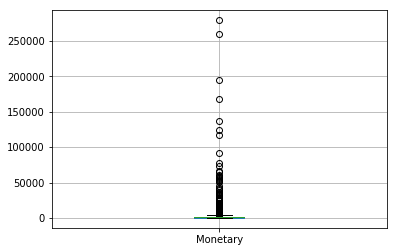

In [65]:
features.iloc[:,5:6].boxplot()

In [66]:
TQ1 = features['Monetary'].quantile(0.25)
TQ3 = features['Monetary'].quantile(0.95)
TIQR = TQ3 - TQ1
low = TQ1 - (1.5*TIQR)
high = TQ3 + (1.5*TIQR)

Any value below Q1-1.5*IQR or above Q3+1.5*IQR is an Outlier

In [67]:
#Exclude outliers in total spending
normal = features[(features['Monetary'] >= low) & (features['Monetary'] <= high)]

In [68]:
print("Number of customers after deleting outliers {}".format(len(normal)))

Number of customers after deleting outliers 4271


### Keep a complete version of the features for further analysis after applying K-means

In [69]:
#all_features = features.drop(['NumberOfProducts','UniqueNumberOfProducts','MinSpendingPerTransaction','MaxSpendingPerTransaction'],axis=1)
all_features = normal #drop(['NumberOfProducts','MinSpendingPerTransaction','MaxSpendingPerTransaction'],axis=1)

In [70]:
#Exclude some columns before applying kmeans
features = normal.drop(['CustomerID','NumberOfProducts','MinSpendingPerOrder','MaxSpendingPerOrder','C0','C1','C2','C3','C4',1,2,3,4,5,6,6,7,8,9,10,11,12],axis=1)
features.head(0)

,Frequancy,AvgSpendingPerOrder,Monetary,Recency,UniqueNumberOfProductsPerOrder,AvgProductsPerOrder


In [71]:
info_(features)

,# of nulls,% of nulls,Types
Frequancy,0,0.0,int64
AvgSpendingPerOrder,0,0.0,float64
Monetary,0,0.0,float64
Recency,0,0.0,int64
UniqueNumberOfProductsPerOrder,0,0.0,int64
AvgProductsPerOrder,0,0.0,float64


### Analyze key statistics of the dataset

Check mean and standard
deviation

In [72]:
features.describe().round(3)

,Frequancy,AvgSpendingPerOrder,Monetary,Recency,UniqueNumberOfProductsPerOrder,AvgProductsPerOrder
count,4271.000,4271.000,4271.000,4271.000,4271.000,4271.000
mean,3.747,358.800,1319.558,93.784,58.382,22.329
std,4.616,373.019,1800.121,100.304,67.751,20.282
min,1.000,3.750,3.750,1.000,1.000,1.000
25%,1.000,177.133,302.410,18.000,15.000,9.500
50%,2.000,286.717,656.630,52.000,35.000,17.000
75%,4.000,417.290,1567.585,145.000,76.000,28.472
max,90.000,9341.260,13375.870,374.000,816.000,259.000


## Data Transformation

Kmeans uses distance-based measurements to determine the similarity between data points, so it works well if we standardize the data to have a mean of zero and a standard deviation of one 

In [73]:
transformed = features

### Normlize the dataset 

###### We will not use it for the final clustring

In [49]:
transformed = transformed + 0.0000000001 #Avoid the zero
transformed = np.log(transformed)
transformed.describe()

,Frequancy,AvgSpendingPerOrder,Monetary,Recency,UniqueNumberOfProductsPerOrder,AvgProductsPerOrder
count,4.271000e+03,4271.000000,4271.000000,4.271000e+03,4.271000e+03,4.271000e+03
mean,9.048397e-01,5.615661,6.520500,3.800282e+00,3.468295e+00,2.742203e+00
std,8.529688e-01,0.714736,1.170838,1.409493e+00,1.203494e+00,9.219563e-01
min,1.000000e-10,1.321756,1.321756,1.000000e-10,1.000000e-10,1.000000e-10
25%,1.000000e-10,5.176903,5.711784,2.890372e+00,2.708050e+00,2.251292e+00
50%,6.931472e-01,5.658495,6.487121,3.951244e+00,3.555348e+00,2.833213e+00
75%,1.386294e+00,6.033781,7.357291,4.976734e+00,4.330733e+00,3.348928e+00
max,4.499810e+00,9.142196,9.501208,5.924256e+00,6.704414e+00,5.556828e+00


### Standardize the dataset
#### Standardizing mean and standard deviation


In [74]:
#Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformed = scaler.fit_transform(transformed)
transformed = pd.DataFrame(transformed, columns=features.columns)
transformed.describe()

,Frequancy,AvgSpendingPerOrder,Monetary,Recency,UniqueNumberOfProductsPerOrder,AvgProductsPerOrder
count,4.271000e+03,4.271000e+03,4.271000e+03,4.271000e+03,4.271000e+03,4.271000e+03
mean,-1.689444e-16,-2.201730e-17,-1.089817e-16,7.481203e-17,-3.361936e-17,6.680899e-17
std,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00
min,-5.952020e-01,-9.519410e-01,-7.310407e-01,-9.251370e-01,-8.470525e-01,-1.051717e+00
25%,-5.952020e-01,-4.870752e-01,-5.651103e-01,-7.556325e-01,-6.403899e-01,-6.325827e-01
50%,-3.785574e-01,-1.932665e-01,-3.683116e-01,-4.166234e-01,-3.451577e-01,-2.627587e-01
75%,5.473180e-02,1.568195e-01,1.377996e-01,5.106660e-01,2.600684e-01,3.029351e-01
max,1.868617e+01,2.408327e+01,6.698284e+00,2.793992e+00,1.118366e+01,1.167023e+01


## Apply K-Means

### Select the Optimal K number

There are different approaches that can be used to select the optimal number of clusters for a K-Means model.
1. The Elbow Criterion
2. Silhouette Coefficient
3. Experimentation and interpretation (from business perspective)

###  Find the Number of Clusters using Sum-of-Squared-Errors (SSE)

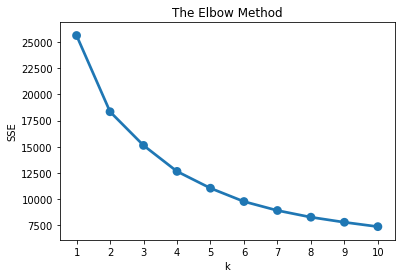

In [75]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(transformed)
    sse[k] = kmeans.inertia_
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Ideally, we want to choose the point on the elbow chart where the SSE stops decreasing at an increasing rate — i.e. the point where the change gradient of between the number of clusters becomes constant.

###  Find the Number of Clusters using silhouette coefficient

In [76]:
# Use silhouette coefficient to determine the best number of clusters
from sklearn.metrics import silhouette_score

for n_cluster in [3,4,5,6,8,10]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
       transformed)
    
    silhouette_avg = silhouette_score(
        transformed, 
        kmeans.labels_)
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 3 Clusters: 0.3211
Silhouette Score for 4 Clusters: 0.3426
Silhouette Score for 5 Clusters: 0.3449
Silhouette Score for 6 Clusters: 0.3363
Silhouette Score for 8 Clusters: 0.3378
Silhouette Score for 10 Clusters: 0.3261


Using both SSE and silhouette we select the number of K = 5 

In [77]:
#Import KMeans from skLearn
from sklearn.cluster import KMeans
# Choose k=5 and fit data set to k-means model
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(transformed)
# Assign k-means labels to cluster labels
cluster_labels = kmeans.labels_
# Assign cluster labels to original pre-transformed data set
transformed_k4 = all_features.assign(Cluster = cluster_labels)
# Group data set by k-means cluster
clusters_info = transformed_k4.groupby(['Cluster']).agg('mean')

In [78]:
len(transformed_k4)

4271

### Number of customers in each cluster 

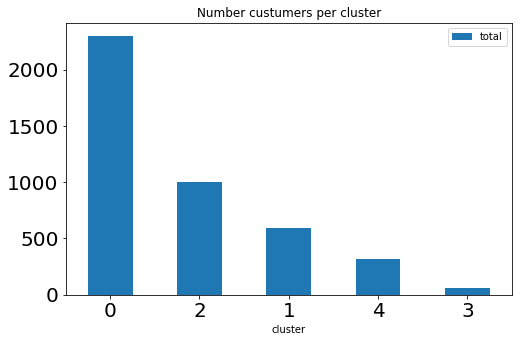

In [80]:
tdf = pd.DataFrame(transformed_k4['Cluster'].value_counts().reset_index()).rename(columns={'index':'cluster','Cluster':'total'})

tdf.plot.bar(x="cluster", y="total", rot=0, title="Number custumers per cluster",figsize=(8,5),fontsize=20);


In [81]:
#% of customers in each cluster
ptdf = transformed_k4['Cluster'].value_counts() /len(transformed_k4) * 100
ptdf

0    53.804730
2    23.413720
1    13.954577
4     7.468977
3     1.357996
Name: Cluster, dtype: float64

# Gaining a better understanding of clusters behaviours

We can understand our customers behaviours in each segmant by displaying the mean of each variable we are intereted in. First we will take the original dataset (with clusters information) and group customers by cluster. Then we will aggregate all variables

In [82]:
transformed_k4.groupby(['Cluster']).agg(['mean']).T

,Cluster,0,1,2,3,4
CustomerID,mean,15291.280679,15295.451342,15383.784000,14681.051724,15248.407524
Frequancy,mean,3.211923,3.555369,1.465000,2.189655,15.401254
MinSpendingPerOrder,mean,201.917903,350.173070,233.933150,1992.001379,117.609436
MaxSpendingPerOrder,mean,401.562198,732.314681,293.789690,3056.856897,973.745862
AvgSpendingPerOrder,mean,292.343632,521.904196,261.978383,2516.425711,444.025744
Monetary,mean,920.752389,1653.359815,371.660260,4885.530345,5891.911129
Recency,mean,46.563098,53.807047,249.576000,105.672414,18.106583
UniqueNumberOfProductsPerOrder,mean,38.811140,131.228188,20.367000,81.344828,178.260188
NumberOfProducts,mean,48.058747,172.352349,21.909000,99.879310,330.144201
AvgProductsPerOrder,mean,15.996576,54.704553,15.671525,49.660057,23.354638


### Number of unique countries in each cluster sorted on the total number of orders

In [92]:
for i in [0,1,2,3,4]:
    cno = i
    IDs = transformed_k4[transformed_k4['Cluster']==cno]['CustomerID']
    values = pd.DataFrame(df[df['CustomerID'].isin(IDs)]['Country'].value_counts()).reset_index()
    print("Unique Countries in cluster {} is {}".format(cno, len(values)))
    print(values)

Unique Countries in cluster 0 is 27
                 index  Country
0       United Kingdom   100756
1               France     2704
2              Germany     2180
3              Belgium      905
4                Spain      458
5                Italy      378
6             Portugal      355
7          Switzerland      326
8               Poland      325
9              Finland      287
10           Australia      247
11             Denmark      226
12         Netherlands      217
13              Sweden      212
14              Norway      184
15              Greece       88
16              Israel       77
17     Channel Islands       76
18              Cyprus       72
19             Austria       69
20               Malta       64
21  European Community       57
22                 USA       56
23         Unspecified       54
24               Japan       37
25      Czech Republic       24
26              Canada        5
Unique Countries in cluster 1 is 21
                   index  Countr

### Number of unique countries in each cluster sorted based on the total spending

In [93]:
for i in [0,1,2,3,4]:
    cno = i
    IDs = transformed_k4[transformed_k4['Cluster']==cno]['CustomerID']
    values = pd.DataFrame(df[df['CustomerID'].isin(IDs)].groupby(['InvoiceNo']).agg({'TotalAmount':'sum','CustomerID':'first','Country':'first'})\
.groupby(by=['Country']).agg({'TotalAmount':'sum'})).sort_values('TotalAmount',ascending=False)
    print("Unique Countries in cluster {} is {}".format(cno, len(values)))
    print(values)

Unique Countries in cluster 0 is 27
                    TotalAmount
Country                        
United Kingdom       1900505.49
France                 54295.57
Germany                48596.59
Belgium                17585.35
Finland                10197.87
Italy                   8729.83
Spain                   8512.87
Switzerland             8431.90
Portugal                8133.96
Poland                  6974.65
Denmark                 6966.15
Australia               5929.25
Sweden                  4691.41
Channel Islands         3918.56
Netherlands             3881.22
Norway                  3505.96
Cyprus                  2676.99
Israel                  2347.88
Austria                 1932.97
USA                     1616.93
Greece                  1376.97
Malta                   1165.09
European Community      1159.25
Unspecified             1082.18
Japan                    835.80
Czech Republic           786.74
Canada                    51.56
Unique Countries in cluster 1 is 21


### Compare the AVG spending per order

C:\Users\shahad\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


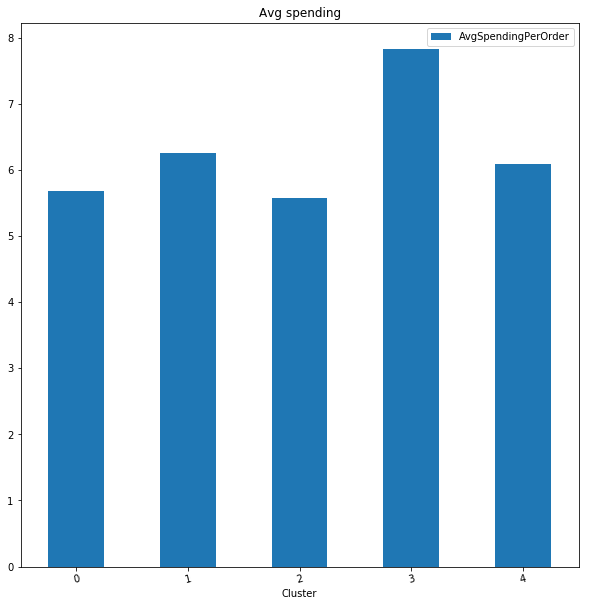

In [94]:
cluster_info_log = np.log(clusters_info)
cluster_info_log[['AvgSpendingPerOrder']].plot.bar(rot=14,title="Avg spending",figsize=(10,10));
plt.show(block=True)

### Compare the AVG spending per category

In [95]:
clusters_info.index

Int64Index([0, 1, 2, 3, 4], dtype='int64', name='Cluster')

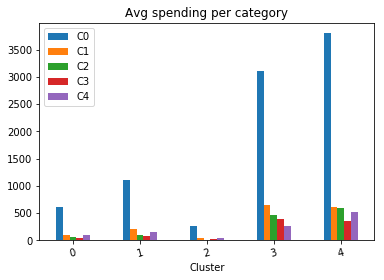

In [96]:
import matplotlib.pyplot as plot

clusters_info[['C0','C1','C2','C3','C4']].plot.bar(rot=15, title="Avg spending per category");
plot.show(block=True);

Let's find more about our clusters, we will start with the cluster with highest number of custumer 

### Compare AVG spending per Month

The dataset covers a period of one year. So the information of total spending per month does not conclude any insights regaeding the pattern of purchasing over time. We need more data to conclude any thing. However, we can knoo from these data and the variance between months how many custumers are recurring or those who buy occasionally in general

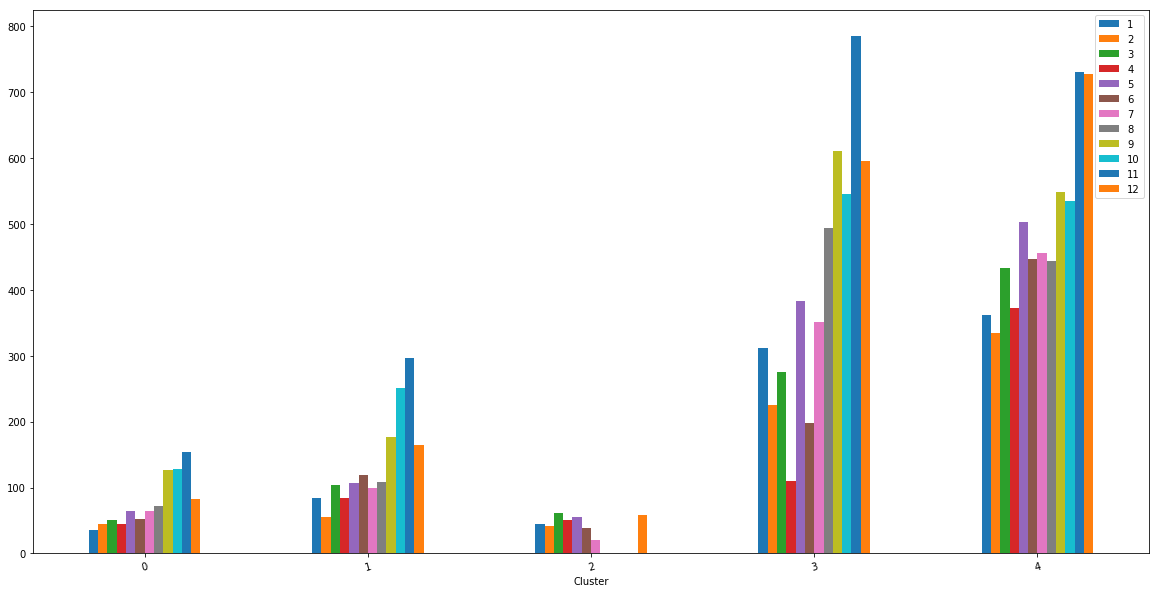

In [84]:
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
clusters_info[[1,2,3,4,5,6,7,8,9,10,11,12]].plot.bar(rot=15, title="",figsize=(20,10));
plot.figure(figsize=(400,400))
plot.show(block=True);

## Scatter plots

The scatter plots below shows the relashionship between Monetary and frequency for each cluster

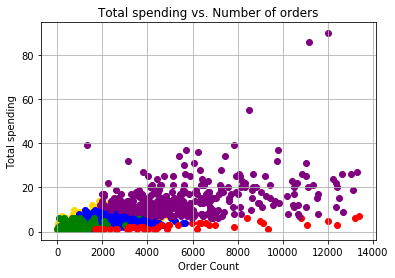

In [87]:
#cluster 0
plt.scatter(
    transformed_k4.loc[transformed_k4['Cluster'] == 0]['Monetary'], 
    transformed_k4.loc[transformed_k4['Cluster'] == 0]['Frequancy'],
    c='gold'
)
#Cluster 1

plt.scatter(
    transformed_k4.loc[transformed_k4['Cluster'] == 1]['Monetary'], 
    transformed_k4.loc[transformed_k4['Cluster'] == 1]['Frequancy'],
    c='blue'
)

#Cluster 2
plt.scatter(
    transformed_k4.loc[transformed_k4['Cluster'] == 2]['Monetary'], 
    transformed_k4.loc[transformed_k4['Cluster'] == 2]['Frequancy'],
    c='green'
)

#Cluster 3

plt.scatter(
    transformed_k4.loc[transformed_k4['Cluster'] == 3]['Monetary'], 
    transformed_k4.loc[transformed_k4['Cluster'] == 3]['Frequancy'],
    c='red'
)
#Cluster 4
plt.scatter(
    transformed_k4.loc[transformed_k4['Cluster'] == 4]['Monetary'], 
    transformed_k4.loc[transformed_k4['Cluster'] == 4]['Frequancy'],
    c='purple'
)

plt.title('Total spending vs. Number of orders')
plt.xlabel('Order Count')
plt.ylabel('Total spending')

plt.grid()
plt.show()

# Understanding the Outliers 

Even that we remove outliers from our dataset to perform the clustering, it is very crucial to know more about their behaviors as a separate segment in order to make proper marketing campaign for them (if valuable to our business

### Where are they from?

In [97]:
# Customers with outlier behaviours
#Get the outlier in total spending
outliers = customers #load the entier dataset before removing outlier
outliers = outliers[(outliers['Monetary'] < low) | (outliers['Monetary'] > high)] #get outliers
outliers_ID = outliers['CustomerID']
outliers_values = pd.DataFrame(df[df['CustomerID'].isin(outliers_ID)]['Country'].unique())
outliers_values

,0
0,United Kingdom
1,EIRE
2,Germany
3,France
4,Japan
5,Sweden
6,Netherlands
7,Australia


### What is the max spending and by whome?

In [122]:
outliers = customers #load the entier dataset before removing outlier
outliers = outliers[(outliers['Monetary'] < low) | (outliers['Monetary'] > high)] #get outliers
outliers = outliers.sort_values('Monetary',ascending=False).iloc[1:10,:]
outliers

,CustomerID,Frequancy,MinSpendingPerOrder,MaxSpendingPerOrder,AvgSpendingPerOrder,Monetary,Recency,UniqueNumberOfProductsPerOrder,NumberOfProducts,AvgProductsPerOrder,...,3,4,5,6,7,8,9,10,11,12
4197,18102.0,60,80.60,22206.00,4327.621667,259657.30,1,150,431,7.183333,...,6909.32,1196.96,18165.74,41959.44,22949.76,985.92,49622.18,52681.27,15331.08,39320.15
3725,17450.0,46,34.56,31698.16,4229.365000,194550.79,8,124,337,7.326087,...,13500.50,3585.04,18025.68,5405.48,8485.14,16119.46,75412.64,3935.96,27869.45,3591.24
3006,16446.0,2,2.90,168469.60,84236.250000,168472.50,1,3,3,1.500000,...,0.00,0.00,2.90,0.00,0.00,0.00,0.00,0.00,0.00,168469.60
1879,14911.0,198,1.45,4345.10,688.261212,136275.72,1,1785,5589,28.227273,...,6677.84,4372.32,9186.68,9703.20,13113.58,11895.49,20771.97,18016.39,21970.73,14316.86
55,12415.0,20,61.20,22775.93,6228.226500,124564.53,24,443,713,35.650000,...,16726.84,0.00,12691.16,23426.81,2955.01,21880.44,2941.72,16471.77,6354.88,0.00
1333,14156.0,54,34.68,16774.72,2161.659815,116729.63,10,713,1387,25.685185,...,9694.62,2898.18,5412.18,9707.79,26364.99,4821.89,19623.52,5801.53,6652.68,322.20
3768,17511.0,31,31.00,7059.54,2937.496129,91062.38,3,453,963,31.064516,...,7238.58,2941.80,7213.16,4415.44,7590.01,8419.62,8229.92,5755.45,13522.22,14090.40
0,12346.0,1,77183.60,77183.60,77183.600000,77183.60,326,1,1,1.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2700,16029.0,62,90.00,7810.56,1175.517581,72882.09,39,43,241,3.887097,...,3487.08,1340.40,3353.76,3969.60,2170.08,10471.30,3172.50,24832.80,632.30,13112.52


The max spending is 259657.30  by 14646.0

### What is the best-selling product among them?

In [140]:
outlierdf = pd.DataFrame(outliers[['C0','C1','C2','C3','C4']].sum().sort_values())
outlierdf.index

Index(['C3', 'C2', 'C1', 'C4', 'C0'], dtype='object')

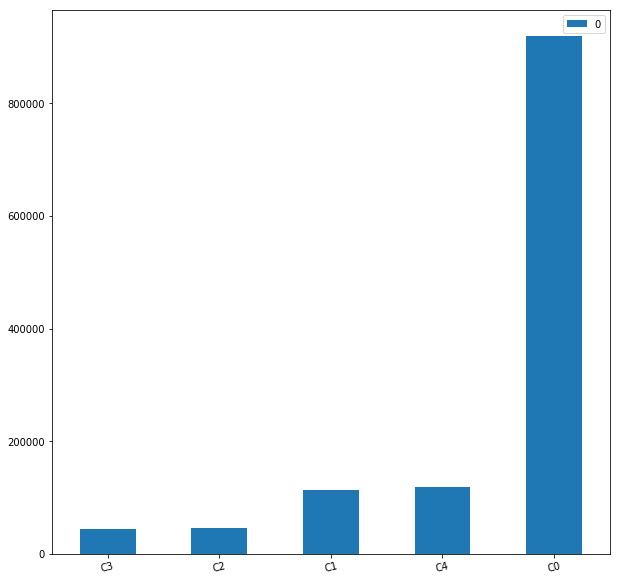

In [141]:
outlierdf.plot.bar(rot=14,title="",figsize=(10,10));
plt.show(block=True)